<a href="https://colab.research.google.com/github/YoonSungLee/AI-Innovation-Square-Project/blob/master/Pratice/MNet_Pratice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical


import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

# loss function definition
def bce_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

<img src="https://i.imgur.com/526umxA.png" width="100%">

In [0]:
def MNet(level=4):
    x = Input(shape=(None, None, 3))    # (batch, None, None, 3)
    inputs = x
    nKernels = 16   # according to the paper
    increase = 16   # according to the paper

    skip_layers = []     # for skip connection
    L_leg = []
    R_leg = []

    # Left Leg
    left_leg = x
    for i in range(level-1):
        left_leg = MaxPooling2D()(left_leg)
        L_leg.append(left_leg)

    # downsampling
    x_tmp = x
    for i in range(level-1):
        x = Conv2D(nKernels, 3, activation='relu', padding='same')(x)   # 16, 32
        x = BatchNormalization()(x)
        x = Concatenate(axis=3)([x, x_tmp])
        x = Conv2D(nKernels+increase, 3, activation='relu', padding='same')(x)   # 32, 48
        x = BatchNormalization()(x)
        skip_layers.append(x)   # skip connection preparation
        x = MaxPooling2D()(x)
        x_tmp = x
        x = Concatenate(axis=3)([x, L_leg[i]])
        nKernels += increase

    # bottleneck
    x_tmp = x
    x = Conv2D(nKernels, 3, activation='relu', padding='same')(x)   # 64
    x = BatchNormalization()(x)
    x = Concatenate(axis=3)([x, x_tmp])
    x = Conv2D(nKernels*2, 3, activation='relu', padding='same')(x)   # 128
    x = BatchNormalization()(x)
    x = Conv2D(nKernels, 3, activation='relu', padding='same')(x)   # 64
    x = BatchNormalization()(x)   

    # upsampling
    for i in range(level-1):
        R_leg.append(x)
        x = UpSampling2D()(x)
        x_tmp = x
        x = Concatenate(axis=3)([x, skip_layers[(len(skip_layers)-1)-i]])
        x = Conv2D(nKernels, 3, activation='relu', padding='same')(x)   # 64
        x = BatchNormalization()(x)
        x = Concatenate(axis=3)([x, x_tmp])
        x = Conv2D(nKernels-increase, 3, activation='relu', padding='same')(x)  # 48
        nKernels -= increase

    # Right leg
    for i in range(level-1):
        if i==0:
            right_leg = R_leg[i]
            break
        right_leg = UpSampling2D()(right_leg)
        right_leg = Concatenate(axis=3)([right_leg, R_leg[i+1]])
    right_leg = UpSampling2D()(right_leg)
    
    # Concat
    x = Concatenate(axis=3)([x, right_leg])
    x = Conv2D(2, 1, activation='softmax', padding='same')(x)   # softmax
    outputs = x

    # model creation
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='rmsprop', loss=bce_dice_loss, metrics=[dice_coef])

    return model

In [0]:
model = MNet()

In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 1 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, None, None, 1 64          conv2d_16[0][0]                  
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, None, None, 1 0           batch_normalization_12[0][0]     
                                                                 input_2[0][0]              

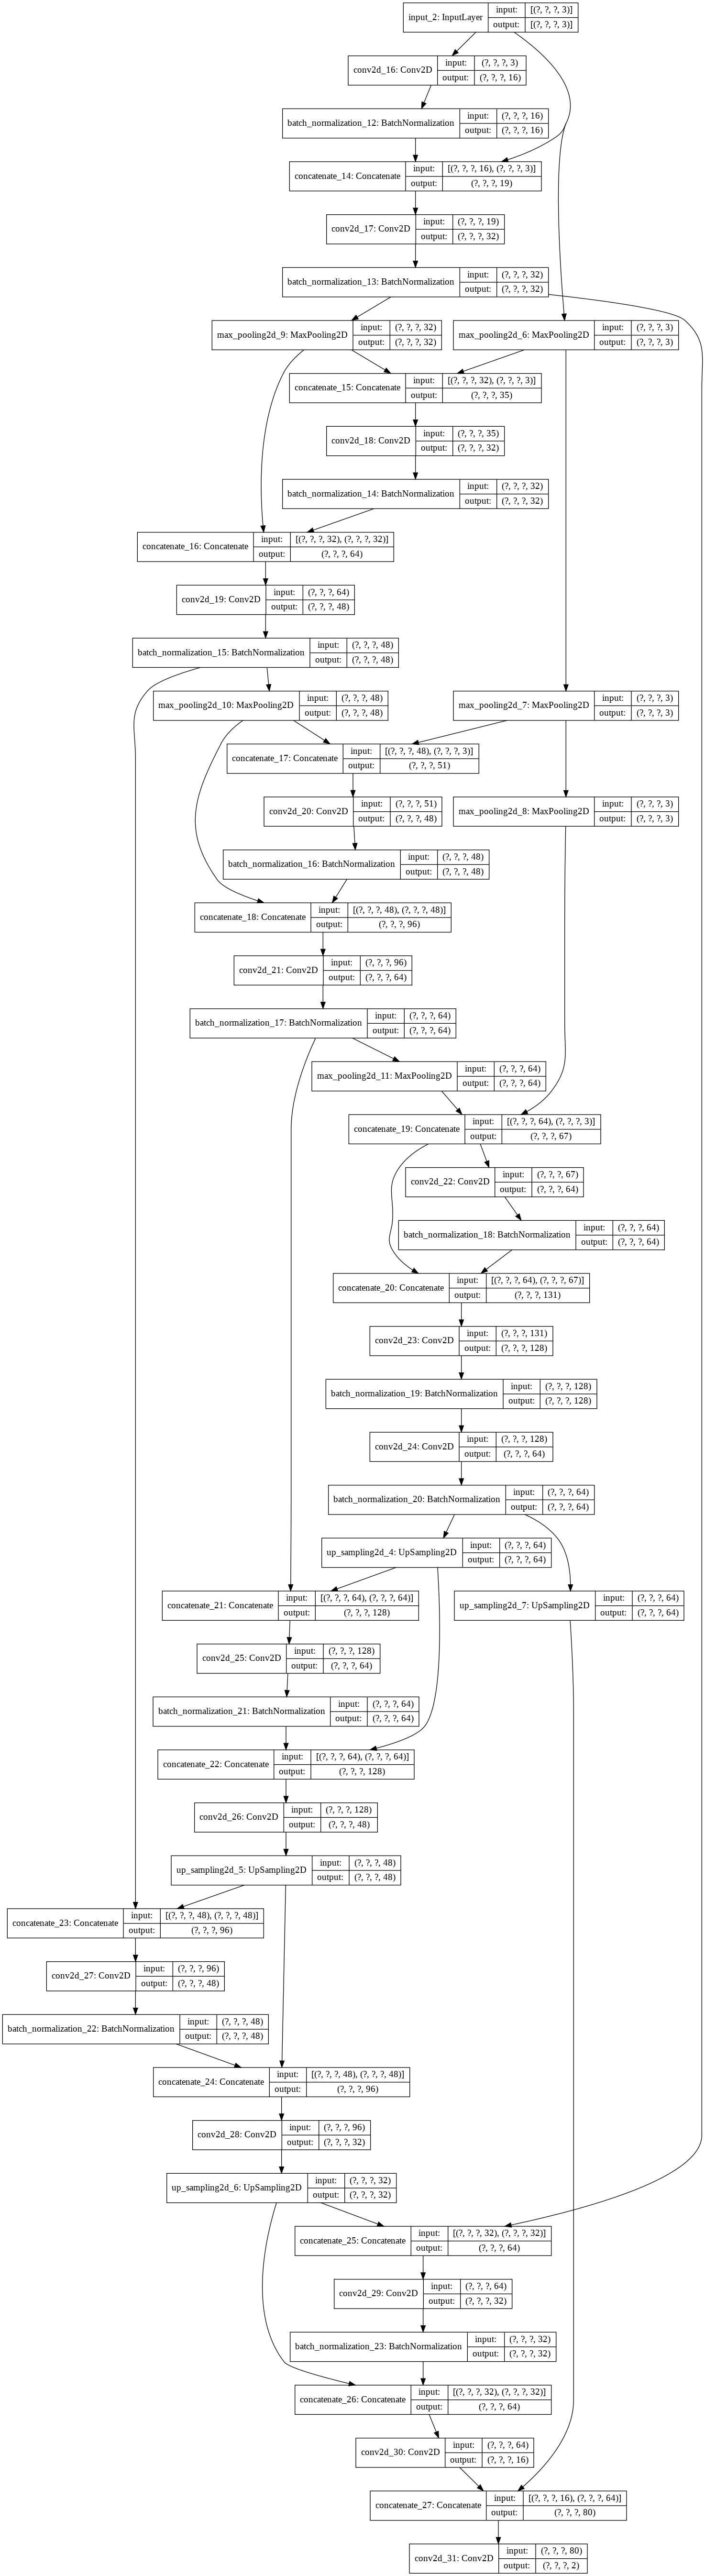

In [8]:
plot_model(model, show_shapes=True, show_layer_names=True)